# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately): **Michelle Ho (Chia Chi Ho)**

Enrollment Status (109A, 121A, 209A, or E109A): **I'm in AC209A. My partner is in CS109A.**

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.tools import add_constant
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

/Users/jasminetong/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [2]:
# Read data
df_train = pd.read_csv('data/Bikeshare_train.csv', index_col="Unnamed: 0")
df_test = pd.read_csv('data/Bikeshare_test.csv', index_col="Unnamed: 0")

df_train.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0
1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0
2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0
3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0
4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0


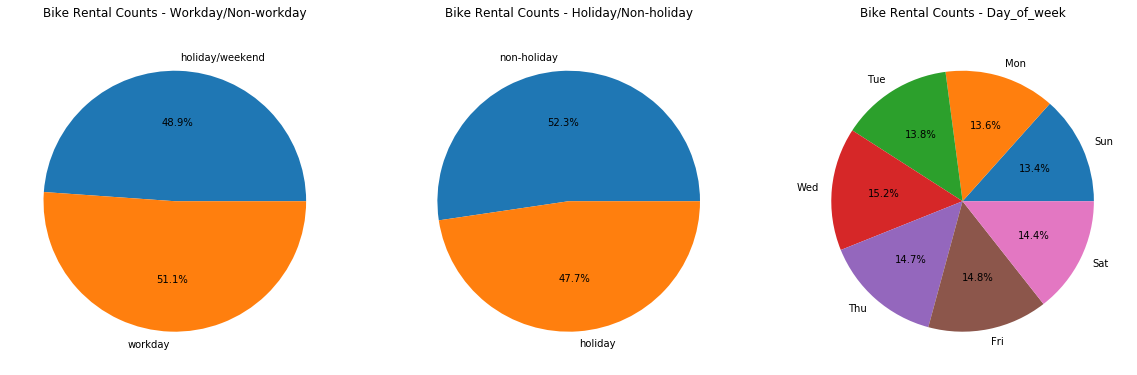

In [3]:
# Looking at how workday/holiday/day_of_week relate to bike rentals
fig, axarr = plt.subplots(1, 3, figsize=(20, 6))

workingday_labels = ['holiday/weekend', 'workday']
workingday_values = df_train.groupby('workingday')['count'].mean()

holiday_labels = ['non-holiday', 'holiday']
holiday_values = df_train.groupby('holiday')['count'].mean()

day_labels = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
day_values = df_train.groupby('day_of_week')['count'].mean()

axarr[0].pie(workingday_values, labels = workingday_labels, autopct='%1.1f%%')
axarr[0].set_title('Bike Rental Counts - Workday/Non-workday\n')

axarr[1].pie(holiday_values, labels = holiday_labels, autopct='%1.1f%%')
axarr[1].set_title('Bike Rental Counts - Holiday/Non-holiday\n')

axarr[2].pie(day_values, labels = day_labels, autopct='%1.1f%%')
axarr[2].set_title('Bike Rental Counts - Day_of_week\n')


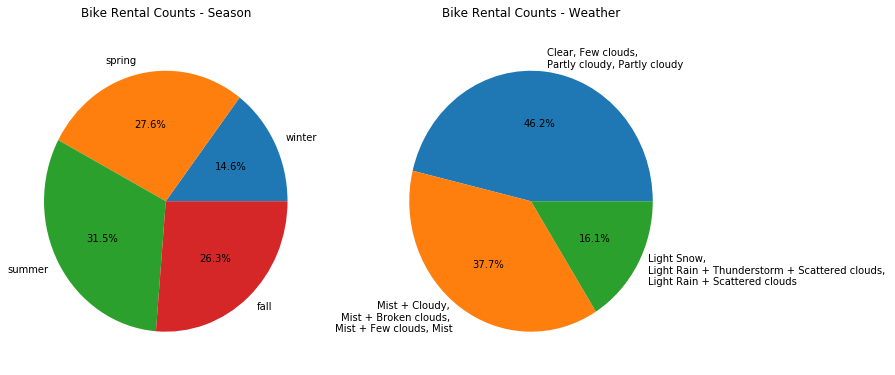

In [4]:
fig1, axarr1 = plt.subplots(1, 2, figsize=(12, 6))

season_labels = ['winter', 'spring', 'summer', 'fall']
season_values = df_train.groupby('season')['count'].mean()

weather_labels = ['Clear, Few clouds, \nPartly cloudy, Partly cloudy', 'Mist + Cloudy, \nMist + Broken clouds, \nMist + Few clouds, Mist', 'Light Snow, \nLight Rain + Thunderstorm + Scattered clouds, \nLight Rain + Scattered clouds']
weather_values = df_train.groupby('weather')['count'].mean()

axarr1[0].pie(season_values, labels = season_labels, autopct='%1.1f%%')
axarr1[0].set_title('Bike Rental Counts - Season\n')

axarr1[1].pie(weather_values, labels = weather_labels, autopct='%1.1f%%')
axarr1[1].set_title('Bike Rental Counts - Weather\n')

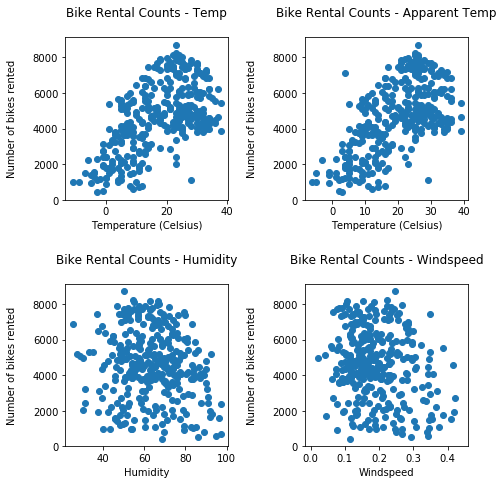

In [5]:
fig2, axarr2 = plt.subplots(2, 2, figsize=(7, 7))

# temperature
axarr2[0,0].scatter(df_train['temp'], df_train['count'])
axarr2[0,0].set_title('Bike Rental Counts - Temp\n')
axarr2[0,0].set_ylabel('Number of bikes rented\n')
axarr2[0,0].set_xlabel('Temperature (Celsius)\n')

# apparent temperature
axarr2[0,1].scatter(df_train['atemp'], df_train['count'])
axarr2[0,1].set_title('Bike Rental Counts - Apparent Temp\n')
axarr2[0,1].set_ylabel('Number of bikes rented\n')
axarr2[0,1].set_xlabel('Temperature (Celsius)\n')

# humidity
axarr2[1,0].scatter(df_train['humidity'], df_train['count'])
axarr2[1,0].set_title('Bike Rental Counts - Humidity\n')
axarr2[1,0].set_ylabel('Number of bikes rented\n')
axarr2[1,0].set_xlabel('Humidity\n')

# windspeed
axarr2[1,1].scatter(df_train['windspeed'], df_train['count'])
axarr2[1,1].set_title('Bike Rental Counts - Windspeed\n')
axarr2[1,1].set_ylabel('Number of bikes rented\n')
axarr2[1,1].set_xlabel('Windspeed\n')

plt.tight_layout()

In [6]:
print('Mean rentals on a rainy/snowy day is: ')
print(df_train.loc[(df_train['weather']==3.0) | (df_train['weather']==4.0)]['count'].mean())
print('Mean rentals of all training data is: ')
print(df_train['count'].mean())

Mean rentals on a rainy/snowy day is: 
1736.2
Mean rentals of all training data is: 
4598.447129909366


## Answer
- How does the number of bike rentals vary between weekdays and weekends? 
    **The number of bike rentals does not vary significantly between weekdays and weekends.**
    
- How about bike rentals on holidays?
    **The number of bike rentals does not vary significantly between holidays and non-holidays.**
    
- What effect does the season have on the bike rentals on a given day?
    **It appears that there are the least bike rentals in winter and the most bike rentals in summer.**
    
- Is the number of bike rentals lower than average when there is rain or snow?
    **Yes, the mean number of bike rentals when there is rain or snow = 1736.2 while the mean rental on average is about  4600. Number of bike rentals is about 3 times lower than average when there is rain or snow.**

- How does temperature effect bike rentals?
    **Temperature and number of bike rentals appear to have a positive correlation, i.e. There are lower number of bike rentals when temperature is low and higher number of bike rentals when temperature is high. It also appears that there is an inflection point where when temperature gets too hot, the number of bike rental begins to drop. **

- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?
    **None of the numeric attributes have a *clear* non-linear dependence. However, there is an inflection point in number of bike rentals vs. temperature (apparent temperature) plots for which temperatures below the inflection point show positive correlation and temperatures above the inflection point show negative correlation. **


We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

In [7]:
# Create indicator variables for the categorical attributes with 2+ categories
# Drop the first binary column for each of the categorical attribute
df_train_new = pd.get_dummies(df_train, prefix=['season', 'month', 'day_of_week', 'weather'], 
                          columns=['season', 'month', 'day_of_week', 'weather'], drop_first=True)

df_test_new = pd.get_dummies(df_test, prefix=['season', 'month', 'day_of_week', 'weather'], 
                          columns=['season', 'month', 'day_of_week', 'weather'], drop_first=True)
df_train_new.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_2.0,season_3.0,season_4.0,...,month_11.0,month_12.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,weather_2.0,weather_3.0
0,0.0,1.0,24.0,26.0,76.5833,0.118167,6073.0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0.0,1.0,15.0,19.0,73.3750,0.174129,6606.0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
2,0.0,1.0,26.0,28.0,56.9583,0.253733,7363.0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.0,0.0,0.0,4.0,58.6250,0.169779,2431.0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
4,0.0,1.0,23.0,23.0,91.7083,0.097021,1996.0,0,1,0,...,0,0,0,0,1,0,0,0,0,1


In [8]:
# Feature normalization for temp, atemp, humidity and windspeed for Training data
df_train_new['temp'] = (df_train_new['temp'] - df_train['temp'].mean())/df_train['temp'].std()
df_train_new['atemp'] = (df_train_new['atemp'] - df_train['atemp'].mean())/df_train['atemp'].std()
df_train_new['humidity'] = (df_train_new['humidity'] - df_train['humidity'].mean())/df_train['humidity'].std()
df_train_new['windspeed'] = (df_train_new['windspeed'] - df_train['windspeed'].mean())/df_train['windspeed'].std()

df_train_new.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_2.0,season_3.0,season_4.0,...,month_11.0,month_12.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,weather_2.0,weather_3.0
0,0.0,1.0,0.623798,0.650106,0.920664,-0.928758,6073.0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0.0,1.0,-0.180310,-0.054759,0.696852,-0.213502,6606.0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
2,0.0,1.0,0.802489,0.851495,-0.448383,0.803926,7363.0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.0,0.0,-1.520492,-1.565182,-0.332113,-0.269099,2431.0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
4,0.0,1.0,0.534453,0.348021,1.975789,-1.199027,1996.0,0,1,0,...,0,0,0,0,1,0,0,0,0,1


In [9]:
# Feature normalization for test set using training data
df_test_new['temp'] = (df_test_new['temp'] - df_train['temp'].mean())/df_train['temp'].std()
df_test_new['atemp'] = (df_test_new['atemp'] - df_train['atemp'].mean())/df_train['atemp'].std()
df_test_new['humidity'] = (df_test_new['humidity'] - df_train['humidity'].mean())/df_train['humidity'].std()
df_test_new['windspeed'] = (df_test_new['windspeed'] - df_train['windspeed'].mean())/df_train['windspeed'].std()

df_test_new.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_2.0,season_3.0,season_4.0,...,month_11.0,month_12.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,weather_2.0,weather_3.0
0,0.0,1.0,-1.341801,-1.363792,-0.500703,0.040945,3830.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.0,1.0,-1.431146,-1.665877,0.132958,2.036025,2114.0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,0.0,1.0,1.695943,1.757749,-0.457103,-0.523392,915.0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0.0,1.0,-0.805728,-0.759623,-0.997746,0.986696,4322.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0.0,0.0,0.981180,0.952190,0.441062,0.311061,6591.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
fd = open("data/yearinfo.json","w")
json.dump(yearinfo, fd)
fd.close()

In [10]:
# new training data attributes
df_train_new.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_2.0,season_3.0,season_4.0,...,month_11.0,month_12.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,weather_2.0,weather_3.0
count,331.000000,331.000000,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,331.000000,331.000000,331.000000,331.000000,...,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,0.033233,0.670695,-6.976628e-17,-1.227618e-16,-7.808457e-16,1.543579e-15,4598.447130,0.259819,0.265861,0.256798,...,0.093656,0.066465,0.175227,0.135952,0.123867,0.123867,0.145015,0.135952,0.329305,0.030211
std,0.179515,0.470672,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1935.319338,0.439199,0.442459,0.437528,...,0.291790,0.249471,0.380736,0.343256,0.329929,0.329929,0.352649,0.343256,0.470672,0.171428
min,0.000000,0.000000,-2.503291e+00,-2.572131e+00,-2.648736e+00,-2.152869e+00,431.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,-8.504011e-01,-8.603176e-01,-7.452412e-01,-7.381149e-01,3370.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,8.772587e-02,1.466312e-01,-6.562743e-03,-1.579037e-01,4648.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,8.024892e-01,7.508005e-01,7.055719e-01,5.693478e-01,5981.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.874634e+00,1.959139e+00,2.362380e+00,2.949989e+00,8714.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
# new test data attributes
df_test_new.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_2.0,season_3.0,season_4.0,...,month_11.0,month_12.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,weather_2.0,weather_3.0
count,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,...,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000
mean,0.02500,0.695000,-0.128713,-0.121217,-0.076029,-0.008111,4514.21250,0.245000,0.250000,0.232500,...,0.072500,0.100000,0.117500,0.147500,0.157500,0.157500,0.140000,0.150000,0.345000,0.02750
std,0.15632,0.460984,1.052309,1.061183,0.988182,0.983825,2092.60635,0.430626,0.433555,0.422955,...,0.259639,0.300376,0.322418,0.355048,0.364728,0.364728,0.347422,0.357519,0.475964,0.16374
min,0.00000,0.000000,-2.324601,-2.370741,-4.421814,-1.858750,22.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.00000,0.000000,-1.073765,-1.061707,-0.879771,-0.714163,2875.25000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.00000,1.000000,-0.180310,-0.155453,-0.092312,-0.098286,4516.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,0.00000,1.000000,0.802489,0.851495,0.665606,0.534842,6174.75000,0.000000,0.250000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000
max,1.00000,1.000000,1.963980,2.261224,2.202511,4.046877,10045.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


## Answers
Why can't they be directly used as predictors? **Categorical attributes with 2+ categories cannot be directly used as predictors in linear regression because we loose interpretability. For instance, bike rental at season=1.25 is uninterpretable. **

Why is it okay to not have a binary column for the $K_j$-th category? **It is okay to not have a binary column for the $K_j$-th category because it is deterministic once the $K_{j-1}$ categories are known. Consider the following scenarios: **
- **if any of the $K_{j-1}$ categories is 1, $K_j$-th category is 0**
- **alternatively, if all of the $K_{j-1}$ categories are 0, $K_j$-th category must be 1**

Why shouldn't we include the test set observations in computing the mean and SD? ** We should not include the test set observations in feature normalization because we would contaminate the training (model building) process with information from the test set, thereby compromising our ability to test the generalizability of the resulting model to future data.** 

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [12]:
all_predictors = list(df_train_new.columns)
all_predictors.remove('count') # remove count from predictor list because it is the response variable
all_predictors

['holiday',
 'workingday',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'season_2.0',
 'season_3.0',
 'season_4.0',
 'month_2.0',
 'month_3.0',
 'month_4.0',
 'month_5.0',
 'month_6.0',
 'month_7.0',
 'month_8.0',
 'month_9.0',
 'month_10.0',
 'month_11.0',
 'month_12.0',
 'day_of_week_1.0',
 'day_of_week_2.0',
 'day_of_week_3.0',
 'day_of_week_4.0',
 'day_of_week_5.0',
 'day_of_week_6.0',
 'weather_2.0',
 'weather_3.0']

In [13]:
# features with all predictors
X_train_all = add_constant(df_train_new[all_predictors].values)
X_test_all = add_constant(df_test_new[all_predictors].values)

# response 
y_train = df_train_new['count']
y_test = df_test_new['count']

# fit the multiple regression model
regression_model_all = sm.OLS(y_train, X_train_all).fit()

# predict with regression model
y_hat_train_all = regression_model_all.predict(X_train_all)
y_hat_test_all = regression_model_all.predict(X_test_all)

# model performance
r2_train_all = r2_score(y_train, y_hat_train_all)
r2_test_all = r2_score(y_test, y_hat_test_all)

p_vals_all = regression_model_all.pvalues
print('R-squared for the train set is: %f' %r2_train_all)
print('R-squared for the test set is: %f' %r2_test_all)
print('F-stat:', regression_model_all.fvalue)
print('significant p-values: \n', p_vals_all[p_vals_all<0.05])
print('predictors with significant p-values: ', all_predictors[4], ',', all_predictors[5], ',', all_predictors[8],',', all_predictors[27])
print(regression_model_all.summary())

R-squared for the train set is: 0.576128
R-squared for the test set is: 0.249342
F-stat: 15.2532867596
significant p-values: 
 const    9.368885e-16
x5       2.020827e-06
x6       1.744235e-03
x9       1.612408e-02
x28      3.025734e-03
dtype: float64
predictors with significant p-values:  humidity , windspeed , season_4.0 , weather_3.0
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     15.25
Date:                Tue, 03 Oct 2017   Prob (F-statistic):           6.56e-42
Time:                        20:45:24   Log-Likelihood:                -2832.1
No. Observations:                 331   AIC:                             5720.
Df Residuals:                     303   BIC:                             5827.
Df Model:                    

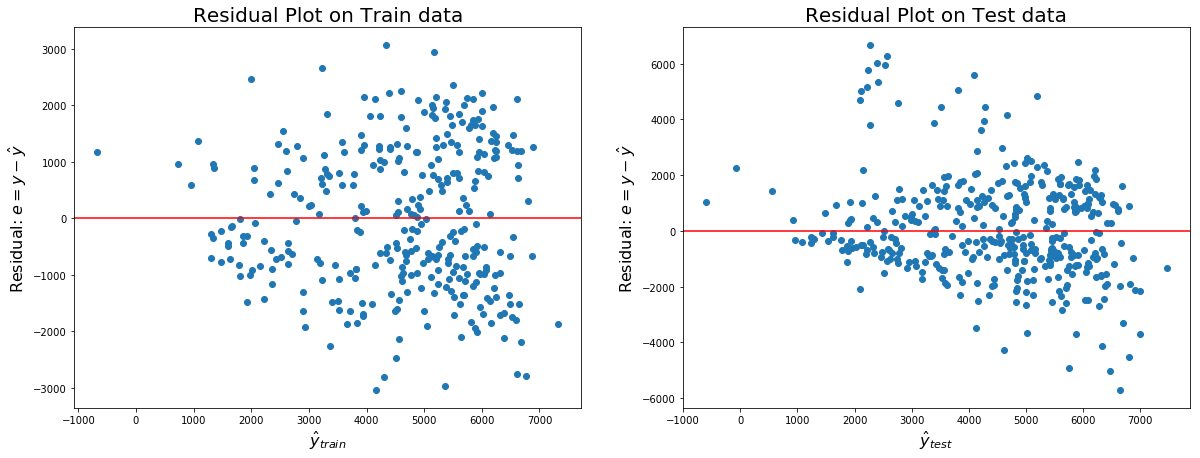

In [14]:
# Residual plot
fig3, axarr3 = plt.subplots(1, 2, figsize=(20, 7))
e_train = np.around(y_train - y_hat_train_all, 2)
e_test = np.around(y_test - y_hat_test_all, 2)

axarr3[0].scatter(x=y_hat_train_all, y=e_train)
axarr3[0].axhline(y = 0, color='r', linestyle='-')
axarr3[0].set_title('Residual Plot on Train data', fontsize=20)
axarr3[0].set_xlabel('$\hat{y}_{train}$', fontsize=16)
axarr3[0].set_ylabel('Residual: ${e} = y - \hat{y}$', fontsize=16)

axarr3[1].scatter(x=y_hat_test_all, y=e_test)
axarr3[1].axhline(y = 0, color='r', linestyle='-')
axarr3[1].set_title('Residual Plot on Test data', fontsize=20)
axarr3[1].set_xlabel('$\hat{y}_{test}$', fontsize=16)
axarr3[1].set_ylabel('Residual: ${e} = y - \hat{y}$', fontsize=16)




## Answer

**Using the all-predictor model, R-squared for the train set is: 0.576128 and R-squared for the test set is: 0.249342**

Which among the predictors have a positive correlation with the number of bike rentals?
    **Season_4.0 (Fall) has a positive correlation and humidity , windspeed, weather_3.0 (Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds) has negative correlations with the number of bike rentals. **
    
    
Does the day of a week have a relationship with bike rentals?
    ** No, the day of a week does not have a relationship with bike rentals based on this model.**


Does the month influence the bike rentals?
    ** No, the month does not influence bike rentals based on this model.**

What effect does a holiday have on bike rentals?
    **A holiday does not have an effect on bike rentals based on this model. **


Is there a difference in the coefficients assigned to temp and atemp? Give an explanation for your observation.
    **Yes, there is a difference. This is because temp and atemp are highly correlated/collinear, resutling in low certainty and high variance in the coefficient estimates. In other words, the coefficients of highly correlated predictors can take on a wider range of values that all give the same RSS compared to the coefficients of less correlated predictors. Therefore, it is not surprising that atemp and temp have different coefficients and that they both are not significant in this model (higher variance also lead to higher p-values that would fail to reject the null hypothesis). **


Residual plot: 
Does the plot reveal a non-linear relationship between the predictors and response? 
   **Yes, the plot reveals a non-linear relationship because the residuals do not distribute uniformly across the x-axis (the predicted response, y-hat).**

What does the plot convey about the variance of the error terms?
    **The variance of the error terms increases with larger y-hat values.**

## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

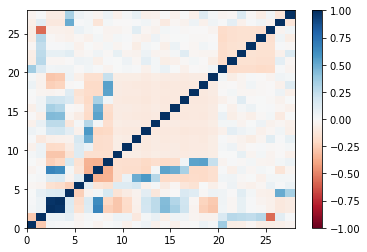

In [15]:
corr_matrix = np.corrcoef(df_train_new[all_predictors].T)
plt.pcolor(corr_matrix, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar()

## Answer
Does the data suffer from multi-collinearity? **From the heatmap of the correlation matrix above, the data clearly suffers from multi-collinearity**

Are there predictors that fall into natural groups based on the correlation values? **Yes, there are preidctors that fall into natural groups. Temp and atemp (col 3 and 4) share highly similar patterns. In addtion, the binary predictors resulting from one-hot encoding all fall into thier natrual groupings where seasons (col 7-9), months (col 10-20), days of week (col 21-26) and weather (col 27, 28) share high similarity within their respective groups.**

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




In [16]:
# function to get bic values from linear regression
def get_bic(X_train, y_train):
    X_train = add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    return model.bic

### Backward selection with bic

In [17]:
# Step-wise backward feature selection/optimization using bic as feature selection criterion
X_train_back_opt = df_train_new[all_predictors].values 
predictors_back_opt = [(all_predictors, get_bic(X_train_back_opt, y_train))] 

for k in range(len(all_predictors), 1, -1): # k goes from 28 to 2
    best_k_predictors = predictors_back_opt[-1][0]
    bics_back_opt = []
    
    for predictor in best_k_predictors:
        k_minus_1 = list(set(best_k_predictors) - set([predictor]))
        X_train_back_opt = df_train_new[k_minus_1].values

        bics_back_opt.append(get_bic(X_train_back_opt, y_train))
    
    best_k_minus_1 = list(set(best_k_predictors) - set([best_k_predictors[np.argmin(bics_back_opt)]]))
    predictors_back_opt.append((best_k_minus_1, np.min(bics_back_opt)))
    
# sort predictors by bic and take the one with smallest bic
best_predictor_set_back_opt = sorted(predictors_back_opt, key=lambda t: t[1])[0]

# optimizaed feature set from step-wise backward selection/optimization
X_train_back_opt = add_constant(df_train_new[best_predictor_set_back_opt[0]].values)
X_test_back_opt = add_constant(df_test_new[best_predictor_set_back_opt[0]].values)  

# fit regression with optimized training features and data
regression_model_back_opt = sm.OLS(y_train, X_train_back_opt).fit()

# predict with feature optimized regression model
y_train_hat_back_opt = regression_model_back_opt.predict(X_train_back_opt)
y_test_hat_back_opt = regression_model_back_opt.predict(X_test_back_opt)

# model performance
r2_train_back_opt = r2_score(y_train, y_train_hat_back_opt)
r2_test_back_opt = r2_score(y_test, y_test_hat_back_opt)

print('best predictor set from backward selection: {}\nbic: {}'.format(best_predictor_set_back_opt[0], best_predictor_set_back_opt[1]))
print('train R^2: {} \ntest R^2: {}'.format(r2_train_back_opt, r2_test_back_opt))


best predictor set from backward selection: ['month_6.0', 'temp', 'weather_3.0', 'humidity', 'season_4.0', 'windspeed', 'season_3.0', 'month_8.0', 'month_7.0', 'season_2.0']
bic: 5743.114545842088
train R^2: 0.5564421321154819 
test R^2: 0.2704811356582887


In [18]:
# Step-wise backward feature selection/optimization using bic as feature selection criterion
X_train_back_opt = df_train_new[all_predictors].values 
predictors_back_opt = [(all_predictors, get_bic(X_train_back_opt, y_train))] 

for k in range(len(all_predictors), 1, -1): # k goes from 28 to 2
    best_k_predictors = predictors_back_opt[-1][0]
    bics_back_opt = []

    for predictor in best_k_predictors:
        k_minus_1 = list(set(best_k_predictors) - set([predictor]))
        X_train_back_opt = df_train_new[k_minus_1].values

        bics_back_opt.append(get_bic(X_train_back_opt, y_train))
    
    best_k_minus_1 = list(set(best_k_predictors) - set([best_k_predictors[np.argmin(bics_back_opt)]]))
    predictors_back_opt.append((best_k_minus_1, np.min(bics_back_opt)))
    
# sort predictors by bic and take the one with smallest bic
best_predictor_set_back_opt = sorted(predictors_back_opt, key=lambda t: t[1])[0]

### Forward selection with bic

In [19]:
# Step-wise foward feature selection/optimization using bic as feature selection criterion
predictors_for_opt = [([], 0)]

for k in range(1, len(all_predictors)):
    best_k_minus_1 = predictors_for_opt[-1][0]

    new_predictors = list(set(all_predictors) - set(best_k_minus_1))
    bics_for_opt = []

    for predictor in new_predictors:

        k_predictors = best_k_minus_1 + [predictor]
        
        X_train_for_opt = df_train_new[k_predictors].values
        X_test_for_opt = df_test_new[k_predictors].values

        bics_for_opt.append(get_bic(X_train_for_opt, y_train))
    
    best_k = best_k_minus_1 + [new_predictors[np.argmin(bics_for_opt)]]
    predictors_for_opt.append((best_k, np.min(bics_for_opt)))

# sort predictors by bic and take the one with smallest bic
best_predictor_set_for_opt = sorted(predictors_for_opt, key=lambda t: t[1])[1]

# optimizaed feature set from step-wise forward selection/optimization
X_train_for_opt = add_constant(df_train_new[best_predictor_set_for_opt[0]].values)
X_test_for_opt = add_constant(df_test_new[best_predictor_set_for_opt[0]].values) 

# fit regression with optimized training features and data
regression_model_for_opt = sm.OLS(y_train, X_train_for_opt).fit()

# predict with feature optimized regression model
y_train_hat_for_opt = regression_model_for_opt.predict(X_train_for_opt)
y_test_hat_for_opt = regression_model_for_opt.predict(X_test_for_opt)

# model performance
r2_train_for_opt = r2_score(y_train, y_train_hat_for_opt)
r2_test_for_opt = r2_score(y_test, y_test_hat_for_opt)

print('best predictor set from forward selection: {}\nbic: {}'.format(best_predictor_set_for_opt[0], best_predictor_set_for_opt[1]))
print('train R^2: {} \ntest R^2: {}'.format(r2_train_for_opt, r2_test_for_opt))


best predictor set from forward selection: ['atemp', 'humidity', 'season_4.0', 'month_9.0', 'season_2.0', 'weather_3.0', 'windspeed']
bic: 5743.099730261509
train R^2: 0.5325133983277169 
test R^2: 0.27579228428983527


## Answer
Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? 

**From backward selection, 'atemp' was eliminated from the 'atemp'/'temp' group; months 2-5 and 9-12 were eliminated from the month group; 'weather_2.0' was eliminated from the weather group; and all of 'day_of_week' + 'holiday' and 'workingday' were eliminated.** 


**From forward selection, 'temp' was eliminated from the 'atemp'/'temp' group; all months were eliminated besides 'month_9.0'; 'season_3.0' was eliminated from the season group; 'weather_2.0' was eliminated from the weather group; and all of 'day_of_week' + 'holiday' and 'workingday' were eliminated.** 


How do the test  R2  scores for the fitted models compare with the model fitted in Part (b) using all predictors?

**The test R2 from the model fitted with all predictors is 0.249342. The test R2 from backward selection is 0.27048, and the test R2 from the forward selection is 0.27579. Both backward and forward selections improved R2 from the all predictor model, with forward selection being the best.**

## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Fit each of the 3 models on the provided left out test set and calculate $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [20]:
from sklearn.model_selection import KFold
n_folds = 10
r2_train_scores = np.zeros((3,10))
r2_valid_scores = np.zeros((3,10))

fold = 0
for train, valid in KFold(n_folds, shuffle=True).split(range(len(df_train_new))): # split training set into train/validation groups, 10 times

    # make feature sets
    X_train_all_cv = add_constant(df_train_new.iloc[train][all_predictors].values)
    X_valid_all_cv = add_constant(df_train_new.iloc[valid][all_predictors].values)
    
    X_train_back_cv = add_constant(df_train_new.iloc[train][best_predictor_set_back_opt[0]].values)
    X_valid_back_cv = add_constant(df_train_new.iloc[valid][best_predictor_set_back_opt[0]].values)
    
    X_train_for_cv = add_constant(df_train_new.iloc[train][best_predictor_set_for_opt[0]].values)
    X_valid_for_cv = add_constant(df_train_new.iloc[valid][best_predictor_set_for_opt[0]].values)
    
    # fit models
    model_all = sm.OLS(y_train[train], X_train_all_cv).fit()
    model_back = sm.OLS(y_train[train], X_train_back_cv).fit()
    model_for = sm.OLS(y_train[train], X_train_for_cv).fit()
    
    # train and valid error for model with all predictors
    r2_train_scores[0, fold] = r2_score(y_train[train], model_all.predict(X_train_all_cv)) 
    r2_valid_scores[0, fold] = r2_score(y_train[valid], model_all.predict(X_valid_all_cv))
    
    # train and valid error for model with predictors selected by backward selection
    r2_train_scores[1, fold] = r2_score(y_train[train], model_back.predict(X_train_back_cv))
    r2_valid_scores[1, fold] = r2_score(y_train[valid], model_back.predict(X_valid_back_cv))
    
    # train and valid error for model with predictors selected by forward selection
    r2_train_scores[2, fold] = r2_score(y_train[train], model_for.predict(X_train_for_cv))
    r2_valid_scores[2, fold] = r2_score(y_train[valid], model_for.predict(X_valid_for_cv))

    fold += 1   

In [21]:
# print average validation R^2 for all three models
print('The average validation R^2 for: ')
print('The all_predictor model is: {}'.format(r2_valid_scores.mean(axis=1)[0]))
print('The backward_selection model is: {}'.format(r2_valid_scores.mean(axis=1)[1]))
print('The forward_selection model is: {}'.format(r2_valid_scores.mean(axis=1)[2]))

The average validation R^2 for: 
The all_predictor model is: 0.3881920220818088
The backward_selection model is: 0.487511847367454
The forward_selection model is: 0.47830776637017014


## Answer
**The average $R^2$ across all 10 validation sets for the forward/backward selected models are higher than the model using all predictors. This is because forward/backward selection tease out the most informative predictors in the training data and reduced redundant information/overfitting.**


**As calculated above, the $R^2$ values on the test set are:**
- **Model with all predictors = 0.249342**
- **Model from backward selection = 0.27048**
- **Model from forward selection = 0.27579.**

**The result in general agrees with cross-validation because both models from backward and forward selection performed better than the model with all predictors. **

